In [84]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import os
import requests

import pandas
import geopandas as gpd

In [71]:
# URL de base des API Hub'Eau
base = "http://hubeau.eaufrance.fr/api"
# Point d'accès de l'API Hub'Eau Niveaux nappe
endpoint = "v1/niveaux_nappes"
# Opération correspondant à la recherche des noms de stations:
#operation = "chroniques"
operation = "stations"

# Nombre de résultats par page
page_size = 1000
# Nombre maximum de résultats pour une recherche
max_results = 20000

# Années des prélèvements
code_departement = ["38",'26']
# Données attendues dans la réponse (cf. données disponibles du modèle Chonique)
fields = [
    "code_bss",
    "x",
    "y",
    "altitude_station",
    "code_commune_insee",
    "nom_commune",
    "code_departement",
    "libelle_departement"
    "code_usage",
    "libelle_usage",
    "volume",
    "code_qualification_volume",
    "libelle_qualification_volume",
    "producteur_donnee"
]

print("Paramétrage OK")

Paramétrage OK


In [72]:
# Paramètres de la recherche des stations: ici toutes celles en isere
parameters = [
    {
        "parameter": "code_departement",
        "value": ",".join(code_departement)
    },
    {
        "parameter": "fields",
        "value": ",".join(fields)
    },
    {
        "parameter": "size",
        "value": page_size
    }
]
# URL de téléchargement des résultats de la recherche
parameters = "&".join([f"{param['parameter']}={param['value']}" for param in parameters])
hubeau_url = f"{base}/{endpoint}/{operation}?{parameters}"
hubeau_url

'http://hubeau.eaufrance.fr/api/v1/niveaux_nappes/stations?code_departement=38,26&fields=code_bss,x,y,altitude_station,code_commune_insee,nom_commune,code_departement,libelle_departementcode_usage,libelle_usage,volume,code_qualification_volume,libelle_qualification_volume,producteur_donnee&size=1000'

V1 de https://callendar.medium.com/tuto-acc%C3%A9der-au-d%C3%A9bit-des-fleuves-fran%C3%A7ais-via-lapi-hubeau-avec-python-f049b9cf4c27

ne fonctionne pas

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from io import StringIO
with urlopen(Request(hubeau_url)) as reponse:
    soup = BeautifulSoup(reponse.read(), 'html.parser')
    df = pd.read_csv(StringIO(str(soup)), sep = ';')

V2 de https://github.com/BRGM/hubeau/blob/master/code_examples/Collecte%20des%20pr%C3%A9l%C3%A8vements%20en%20eau.ipynb

In [73]:
# Récupération de la 1ère page de résultats
response = requests.get(hubeau_url)
# Conversion de la chaîne de texte au format json dans un dictionnaire python
response = response.json()
response

{'count': 130,
 'first': 'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/stations?code_departement=38,26&fields=code_bss,x,y,altitude_station,code_commune_insee,nom_commune,code_departement,libelle_departementcode_usage,libelle_usage,volume,code_qualification_volume,libelle_qualification_volume,producteur_donnee&page=1&size=1000',
 'last': None,
 'prev': None,
 'next': None,
 'api_version': '1.4.1',
 'data': [{'code_bss': '07968X0186/RE11',
   'altitude_station': '277.0',
   'code_departement': '38',
   'code_commune_insee': '38545',
   'nom_commune': 'Vif',
   'x': 5.700698352,
   'y': 45.072061448},
  {'code_bss': '08915X0028/PMA-B1',
   'altitude_station': '306.62',
   'code_departement': '26',
   'code_commune_insee': '26182',
   'nom_commune': 'Mirabel-aux-Baronnies',
   'x': 5.112225223,
   'y': 44.314473115},
  {'code_bss': '08422X0190/F1',
   'altitude_station': '95.0',
   'code_departement': '26',
   'code_commune_insee': '26166',
   'nom_commune': 'Loriol-sur-Drôme',
   'x

In [74]:

if response['count'] > max_results:
    print("Le nombre de résultats dépasse le seuil maximum de {0}. " \
          "Seuls les {0} premiers résultats seront téléchargés".format(max_results))

# Extraction des données de la 1ère page de résultats
data = response['data']
# Initialisation du nombre de résultats requêtés
nb_results = page_size

# Affichage du 1er résultat de recherche
data[0]

{'code_bss': '07968X0186/RE11',
 'altitude_station': '277.0',
 'code_departement': '38',
 'code_commune_insee': '38545',
 'nom_commune': 'Vif',
 'x': 5.700698352,
 'y': 45.072061448}

In [67]:
stations = pd.DataFrame(response['data'])

In [69]:
stations.to_csv('/home/hectorb/DATA/WT/France/isere_drome/stations.csv')

In [8]:
gDB = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.x, stations.y),crs={'init': 'epsg:4326'})


/home/hectorb/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


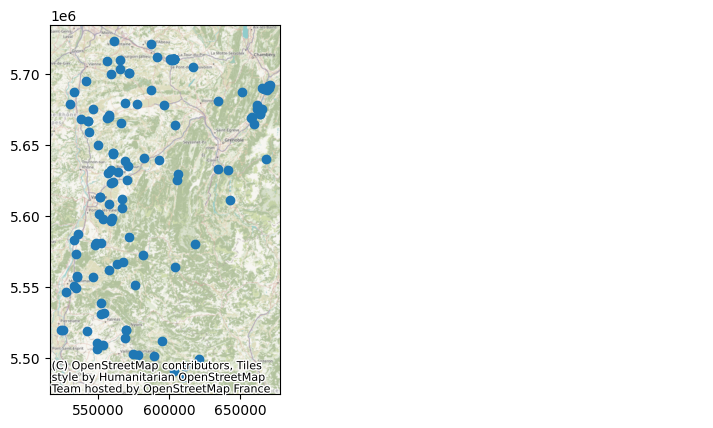

In [17]:
#gDB.plot()
import contextily as cx
gDB_wm=gDB.to_crs(epsg=3857)
ax = gDB_wm.plot()

#for x, y, label in zip(gDB_wm.geometry.x, gDB_wm.geometry.y, gDB_wm.nom_commune):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
#ax.set_xlim(4.5,6.8)
#ax.set_ylim(44.85,45.75)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.HOT)

In [75]:
for dic in data: 
    if dic['nom_commune']=='Vatilieu':
        code_bss = dic['code_bss']

In [76]:
[code_bss]

['07725X0071/F3']

In [77]:
operation = "chroniques"
# Données attendues dans la réponse (cf. données disponibles du modèle Chonique)
fields = [
    "code_bss",
    "longitude",
    "latitude",
    "altitude_station",
    "date_mesure",
    "timestamp_mesure",
    "profondeur_nappe",
    "niveau_nappe_eau",
    "mode_obtention"
]
# Paramètres de la recherche des chroniques
parameters = [
    {
        "parameter": "code_bss",
        "value": ",".join([code_bss])
    }
]

In [78]:
# URL de téléchargement des résultats de la recherche
parameters_str = "&".join([f"{param['parameter']}={param['value']}" for param in parameters])
hubeau_url = f"{base}/{endpoint}/{operation}?{parameters_str}"
hubeau_url

'http://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?code_bss=07725X0071/F3'

In [79]:
# Récupération de la 1ère page de résultats
response = requests.get(hubeau_url)
# Conversion de la chaîne de texte au format json dans un dictionnaire python
response = response.json()
response

{'count': 4591,
 'first': 'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?code_bss=07725X0071/F3&page=1&size=5000',
 'last': None,
 'prev': None,
 'next': None,
 'api_version': '1.4.1',
 'data': [{'code_bss': '07725X0071/F3',
   'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/07725X0071/F3',
   'date_mesure': '2011-07-12',
   'timestamp_mesure': 1310428800000,
   'niveau_nappe_eau': 568.62,
   'mode_obtention': 'Valeur mesurée',
   'statut': 'Donnée contrôlée niveau 2',
   'qualification': 'Correcte',
   'code_continuite': '1',
   'nom_continuite': 'Point initial',
   'code_producteur': '196',
   'nom_producteur': 'Service Géologique Régional Rhône-Alpes (196)',
   'code_nature_mesure': 'N',
   'nom_nature_mesure': 'Naturel',
   'profondeur_nappe': 41.38},
  {'code_bss': '07725X0071/F3',
   'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/07725X0071/F3',
   'date_mesure': '2011-07-13',
   'timestamp_mesure': 1310515200000,
   'niveau_nappe_eau': 568.63,
   'm

In [80]:
tmp = pd.DataFrame(response['data']).loc[:,['date_mesure','niveau_nappe_eau','profondeur_nappe','mode_obtention']].set_index('date_mesure')

In [171]:
tmp.index=pd.to_datetime(tmp.index)

/tmp/ipykernel_59774/739312680.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)


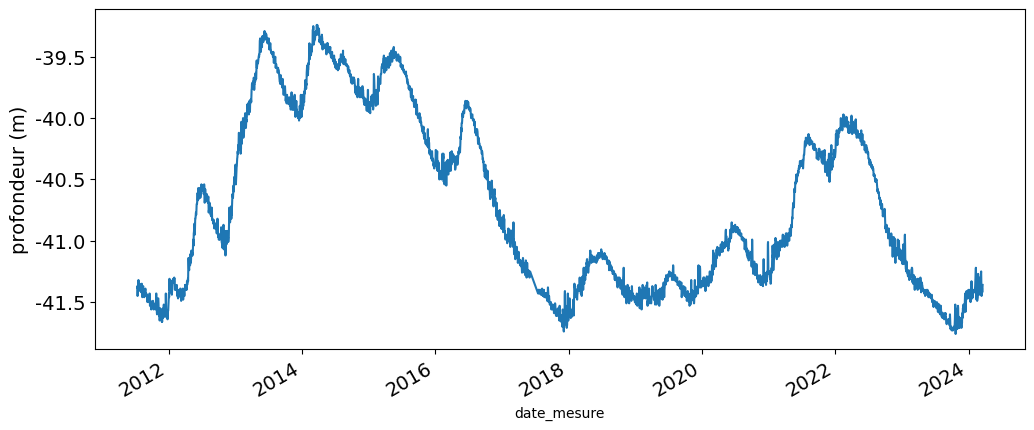

In [454]:
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-tmp.dropna().loc[:,'profondeur_nappe']).plot(ax=axes,fontsize=14)
axes.set_ylabel('profondeur (m)',fontsize=14)
axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)

plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu.png')

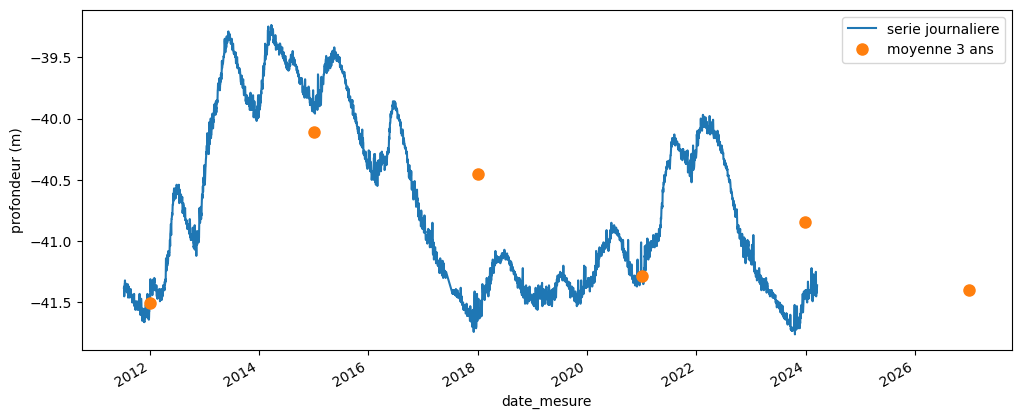

In [191]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-tmp.dropna().loc[:,'profondeur_nappe']).dropna().plot(ax=axes,label='serie journaliere')

(-tmp.dropna().loc[:,'profondeur_nappe']).resample('3Y').mean().dropna().plot(style ='o',markersize=8,ax=axes,label='moyenne 3 ans')
plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_et_moyenne_interannuelle.png')

### Arreté secheresse isere sur les précipitations: 

Niveau 1: déficit marqué des cumuls depuis le 1er octobre de l'année précédente

pas d'autre niveau

### Arreté secheresse isere sur les nappes: 

Niveau 1: niveau piezo inférieur à la moyenne mensuelle (niveau de nappe de fréquence de retour de 1 an sur 2 ou ayant une proba 1/2 de se produire chaque année) et que la tendance est à la baisse

Niveau 2: niveau piezo mensuel quinquennal sec (non dépassé 1 année sur 5 ou de période de retour de 5 ans) et une tendance à la baisse

Niveau 3: niveau piezo mensuel décennal sec (non dépassé 1 année sur 10 ou de période de retour de 10 ans) 

Niveau 4: niveau piezo mensuel vingtennal sec (non dépassé 1 année sur 20 ou de période de retour de 20 ans) 


 soit c'est comme tu l'entends: un niveau unique qui sert de reference, et alors le quantile à aller chercher est 1/(12*T) pour une période de retour de T ans. Ton calcul donne le débit mensuel de retour T mois.

 mais de mémoire c'était le débit mensuel de retour T ans, dont qui varie en fonction du mois. Le niveau décennal sec de janvier ayant un chance sur dix chaque année de se produire en janvier. Idem en fevrier, .....

In [325]:
vat = (-tmp.dropna().loc[:,'profondeur_nappe']).dropna()
vatm = vat.resample('m').mean()

In [326]:
vatm.quantile(0.2)
return2 = pd.Series([vatm.quantile(1/(12*2)),vatm.quantile(1/(12*2))],index=[vatm.index[0],vatm.index[-1]])
return5 = pd.Series([vatm.quantile(1/(12*5)),vatm.quantile(1/(12*5))],index=[vatm.index[0],vatm.index[-1]])
return10 = pd.Series([vatm.quantile(1/(12*10)),vatm.quantile(1/(12*10))],index=[vatm.index[0],vatm.index[-1]])
return20 = pd.Series([vatm.quantile(1/(12*20)),vatm.quantile(1/(12*20))],index=[vatm.index[0],vatm.index[-1]])



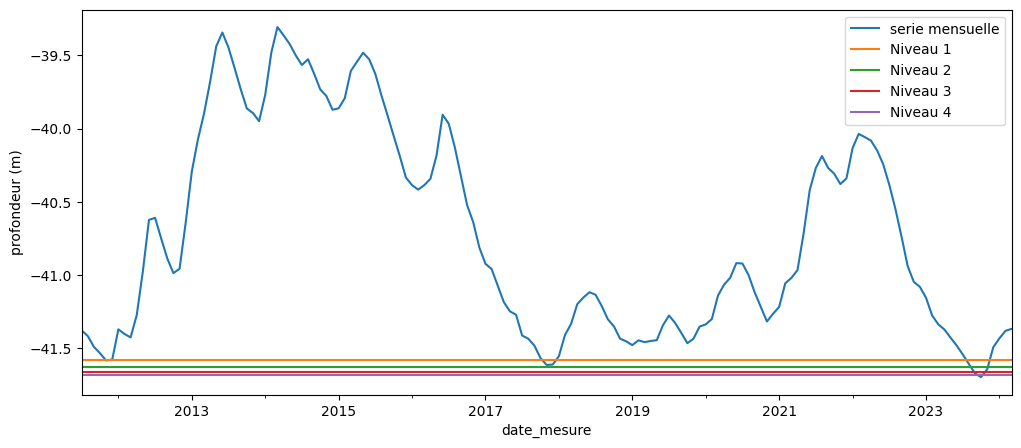

In [327]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))


vatm.plot(ax=axes,label='serie mensuelle')
return2.plot(ax=axes,label='Niveau 1')
return5.plot(ax=axes,label='Niveau 2')
return10.plot(ax=axes,label='Niveau 3')
return20.plot(ax=axes,label='Niveau 4')

plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_niveaux_secheresse.png')

Calcul niveaux V2:

In [328]:
return2bm =vatm.groupby(vatm.index.month).apply(lambda x:x.quantile(1/2))
return5bm =vatm.groupby(vatm.index.month).apply(lambda x:x.quantile(1/5))
return10bm =vatm.groupby(vatm.index.month).apply(lambda x:x.quantile(1/10))
return20bm =vatm.groupby(vatm.index.month).apply(lambda x:x.quantile(1/20))

In [329]:
return2bm

date_mesure
1    -41.153871
2    -41.055357
3    -41.070323
4    -41.014833
5    -40.845000
6    -40.521167
7    -40.609032
8    -40.750323
9    -40.886333
10   -40.986129
11   -41.045333
12   -41.079677
Name: profondeur_nappe, dtype: float64

In [330]:
vatm2b = vatm.copy(deep=True)
vatm5b = vatm.copy(deep=True)
vatm10b = vatm.copy(deep=True)
vatm20b = vatm.copy(deep=True)

In [331]:
for i in range (12):
    vatm2b.loc[(vatm2b.index.month==i+1) & (vatm2b>return2bm[i+1])]=np.nan
    vatm5b.loc[(vatm5b.index.month==i+1) & (vatm5b>return5bm[i+1])]=np.nan
    vatm10b.loc[(vatm10b.index.month==i+1) & (vatm10b>return10bm[i+1])]=np.nan
    vatm20b.loc[(vatm20b.index.month==i+1) & (vatm20b>return20bm[i+1])]=np.nan    

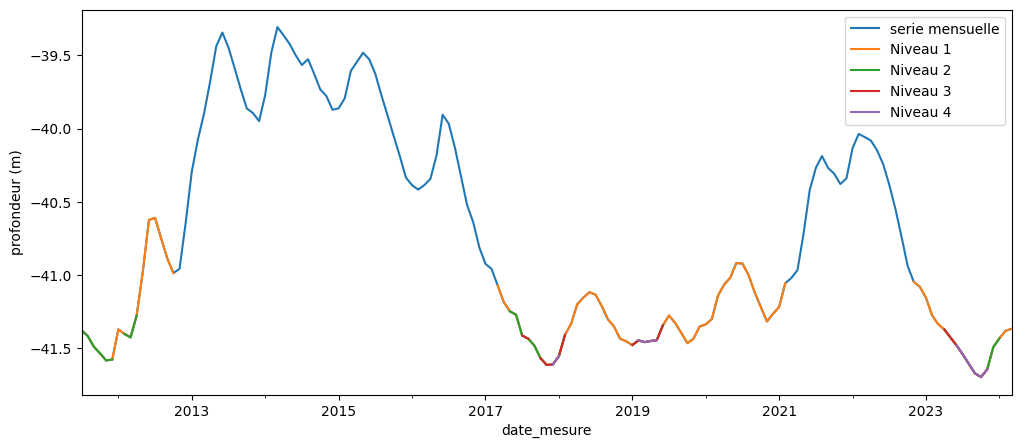

In [332]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))


vatm.plot(ax=axes,label='serie mensuelle')
#"""
vatm2b.plot(ax=axes,label='Niveau 1')
vatm5b.plot(ax=axes,label='Niveau 2')
vatm10b.plot(ax=axes,label='Niveau 3')
vatm20b.plot(ax=axes,label='Niveau 4')
"""
vatm2b.dropna().plot(ax=axes,label='Niveau 1')
vatm5b.dropna().plot(ax=axes,label='Niveau 2')
vatm10b.dropna().plot(ax=axes,label='Niveau 3')
vatm20b.dropna().plot(ax=axes,label='Niveau 4')
"""

plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_niveaux_secheresseV2.png')
#plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_niveaux_secheresseV2b.png')

calcul niveau V3

In [333]:
vatm2c = vatm.copy(deep=True)
vatm5c = vatm.copy(deep=True)
vatm10c = vatm.copy(deep=True)
vatm20c = vatm.copy(deep=True)

for year in np.unique(vatm.index.year):
    if year > 2011:
        vatmtmp = vatm.loc[vatm.index.year<=year].copy(deep=True)
        return2cm =vatmtmp.groupby(vatmtmp.index.month).apply(lambda x:x.quantile(1/2))
        return5cm =vatmtmp.groupby(vatmtmp.index.month).apply(lambda x:x.quantile(1/5))
        return10cm =vatmtmp.groupby(vatmtmp.index.month).apply(lambda x:x.quantile(1/10))
        return20cm =vatmtmp.groupby(vatmtmp.index.month).apply(lambda x:x.quantile(1/20))
        for i in range (12):
            vatm2c.loc[(vatm2c.index.month==i+1) & (vatm2c.index.year==year) & (vatm2c>return2cm[i+1])]=np.nan
            vatm5c.loc[(vatm5c.index.month==i+1) & (vatm2c.index.year==year) & (vatm5c>return5cm[i+1])]=np.nan
            vatm10c.loc[(vatm10c.index.month==i+1) & (vatm2c.index.year==year) & (vatm10c>return10cm[i+1])]=np.nan
            vatm20c.loc[(vatm20c.index.month==i+1) & (vatm2c.index.year==year) & (vatm20c>return20cm[i+1])]=np.nan   

## arretés secheresse

voir arretes_secheresse.ipynb

In [334]:
 arretes = pd.read_csv('/home/hectorb/DATA/WT/France/isere_drome/arretes_secheresse/vatilieu.csv')

In [335]:
arretes.set_index(arretes.columns[0],inplace = True)

In [336]:
arretes.index = pd.to_datetime(arretes.index)

In [337]:
arretes.loc[:,'niv1'] = -41.7*arretes.loc[:,'niv1']
arretes.loc[:,'niv2'] = -41.8*arretes.loc[:,'niv2']
arretes.loc[:,'niv3'] = -41.9*arretes.loc[:,'niv3']
arretes.loc[:,'niv4'] = -42*arretes.loc[:,'niv4']

/tmp/ipykernel_59774/1664266116.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)


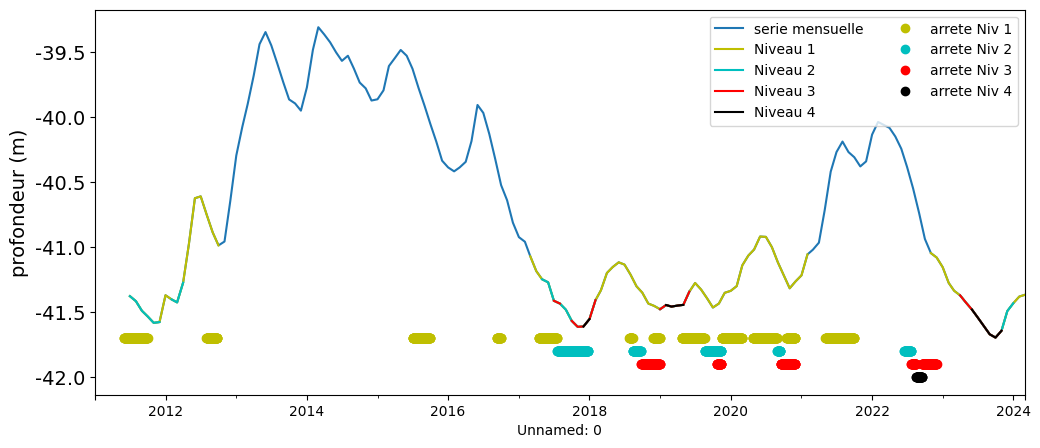

In [453]:
fig, axes = plt.subplots(1,1,figsize=(12,5))


vatm.plot(ax=axes,label='serie mensuelle',fontsize=14)
#"""
vatm2b.plot(c='y',ax=axes,label='Niveau 1')
vatm5b.plot(c='c',ax=axes,label='Niveau 2')
vatm10b.plot(c='r',ax=axes,label='Niveau 3')
vatm20b.plot(c='k',ax=axes,label='Niveau 4')


arretes.loc[:,'niv1'].plot(c='y',style='o',ax=axes,label='arrete Niv 1')
arretes.loc[:,'niv2'].plot(c='c',style='o',ax=axes,label='arrete Niv 2')
arretes.loc[:,'niv3'].plot(c='r',style='o',ax=axes,label='arrete Niv 3')
arretes.loc[:,'niv4'].plot(c='k',style='o',ax=axes,label='arrete Niv 4')
"""
arretes.loc[:,'niv1'].plot(c='y',ax=axes,label='arrete Niv 1')
arretes.loc[:,'niv2'].plot(c='c',ax=axes,label='arrete Niv 2')
arretes.loc[:,'niv3'].plot(c='r',ax=axes,label='arrete Niv 3')
arretes.loc[:,'niv4'].plot(c='k',ax=axes,label='arrete Niv 4')
"""
"""
vatm2b.dropna().plot(ax=axes,label='Niveau 1')
vatm5b.dropna().plot(ax=axes,label='Niveau 2')
vatm10b.dropna().plot(ax=axes,label='Niveau 3')
vatm20b.dropna().plot(ax=axes,label='Niveau 4')
"""

plt.legend(ncol=2)
axes.set_ylabel('profondeur (m)',fontsize=14)
axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)

plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_niveaux_secheresseV2_av_arretes.png')

methode 3

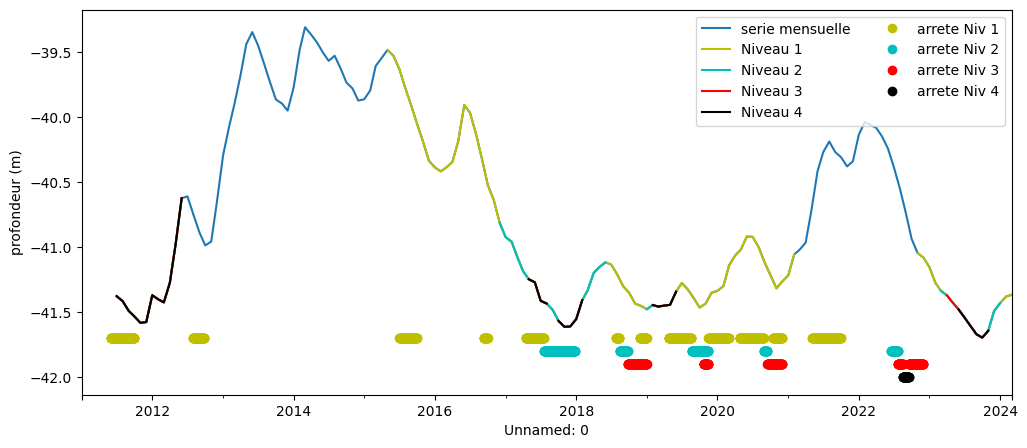

In [346]:

fig, axes = plt.subplots(1,1,figsize=(12,5))


vatm.plot(ax=axes,label='serie mensuelle')
#"""
vatm2c.plot(c='y',style='o',ax=axes,label='Niveau 1')
vatm5c.plot(c='c',style='o',ax=axes,label='Niveau 2')
vatm10c.plot(c='r',style='o',ax=axes,label='Niveau 3')
vatm20c.plot(c='k',style='o',ax=axes,label='Niveau 4')


arretes.loc[:,'niv1'].plot(c='y',style='o',ax=axes,label='arrete Niv 1')
arretes.loc[:,'niv2'].plot(c='c',style='o',ax=axes,label='arrete Niv 2')
arretes.loc[:,'niv3'].plot(c='r',style='o',ax=axes,label='arrete Niv 3')
arretes.loc[:,'niv4'].plot(c='k',style='o',ax=axes,label='arrete Niv 4')
"""
arretes.loc[:,'niv1'].plot(c='y',ax=axes,label='arrete Niv 1')
arretes.loc[:,'niv2'].plot(c='c',ax=axes,label='arrete Niv 2')
arretes.loc[:,'niv3'].plot(c='r',ax=axes,label='arrete Niv 3')
arretes.loc[:,'niv4'].plot(c='k',ax=axes,label='arrete Niv 4')
"""
"""
vatm2b.dropna().plot(ax=axes,label='Niveau 1')
vatm5b.dropna().plot(ax=axes,label='Niveau 2')
vatm10b.dropna().plot(ax=axes,label='Niveau 3')
vatm20b.dropna().plot(ax=axes,label='Niveau 4')
"""

plt.legend(ncol=2)
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_niveaux_secheresseV3_av_arretes.png')

In [350]:
met = pd.read_csv('/home/hectorb/DATA/METEO/France/isere/MENSQ_38_previous-1950-2022.csv',sep=';')

In [358]:
stgeoirs = met.loc[met.NOM_USUEL.str.contains('GEOIRS'),:]

In [359]:
stgeoirs

NUM_POSTE           NOM_USUEL     LAT       LON  ALTI  AAAAMM     RR  \
42733   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  195001   82.5   
42734   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  195002   73.6   
42735   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  195003   23.3   
42736   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  195004   73.9   
42737   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  195005   56.4   
...          ...                 ...     ...       ...   ...     ...    ...   
43419   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  202208   73.0   
43420   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  202209   63.9   
43421   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  202210  100.9   
43422   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  202211   80.3   
43423   38384001  GRENOBLE-ST GEOIRS  45.364  5.313333   384  202212  106.6   

       QRR  NBRR  RR_ME  ...  QNEIGETOTM   NEIGETOTAB  QNEIGETOTAB  \
42733  1.0  31.0    NaN  ...         NaN          NaN          NaN   
42734  1.0  28.0    NaN  ...         NaN          NaN          NaN   
42735  1.0  31.0    NaN  ...         NaN          NaN          NaN   
42736  1.0  30.0    NaN  ...         NaN          NaN          NaN   
42737  1.0  31.0    NaN  ...         NaN          NaN          NaN   
...    ...   ...    ...  ...         ...          ...          ...   
43419  1.0  31.0    NaN  ...         9.0          0.0          9.0   
43420  1.0  30.0    NaN  ...         9.0          0.0          9.0   
43421  1.0  31.0    NaN  ...         9.0          0.0          1.0   
43422  1.0  30.0    NaN  ...         9.0          0.0          1.0   
43423  1.0  31.0    NaN  ...         9.0          6.0          9.0   

       NEIGETOTABDAT  NBJNEIGETOT1  NBJNEIGETOT10  NBJNEIGETOT30  NBJGREL  \
42733            NaN           NaN            NaN            NaN      NaN   
42734            NaN           NaN            NaN            NaN      NaN   
42735            NaN           NaN            NaN            NaN      NaN   
42736            NaN           NaN            NaN            NaN      NaN   
42737            NaN           NaN            NaN            NaN      NaN   
...              ...           ...            ...            ...      ...   
43419            NaN           0.0            0.0            0.0      NaN   
43420            NaN           0.0            0.0            0.0      NaN   
43421            NaN           0.0            0.0            0.0      NaN   
43422            NaN           0.0            0.0            0.0      NaN   
43423           13.0           2.0            0.0            0.0      NaN   

       NBJORAG  NBJBROU  
42733      NaN      NaN  
42734      NaN      NaN  
42735      NaN      NaN  
42736      NaN      NaN  
42737      NaN      NaN  
...        ...      ...  
43419      4.0      1.0  
43420      6.0      1.0  
43421      4.0      6.0  
43422      2.0      7.0  
43423      0.0      9.0  

[691 rows x 162 columns]

In [371]:
stgeoirs.loc[:,'year'] = stgeoirs.loc[:,'AAAAMM'].apply(lambda x: int(str(x)[0:4]))
stgeoirs.loc[:,'month'] = stgeoirs.loc[:,'AAAAMM'].apply(lambda x: int(str(x)[4:6]))

/tmp/ipykernel_59774/2087405673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stgeoirs.loc[:,'year'] = stgeoirs.loc[:,'AAAAMM'].apply(lambda x: int(str(x)[0:4])).copy(deep=True)
/tmp/ipykernel_59774/2087405673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stgeoirs.loc[:,'month'] = stgeoirs.loc[:,'AAAAMM'].apply(lambda x: int(str(x)[4:6])).copy()


In [373]:
stgeoirs.loc[:,'date'] = pd.to_datetime(dict(year=stgeoirs.year, month=stgeoirs.month,day=1))

/tmp/ipykernel_59774/1637703889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stgeoirs.loc[:,'date'] = pd.to_datetime(dict(year=stgeoirs.year, month=stgeoirs.month,day=1))


In [375]:
stgeoirs.set_index('date',inplace=True)

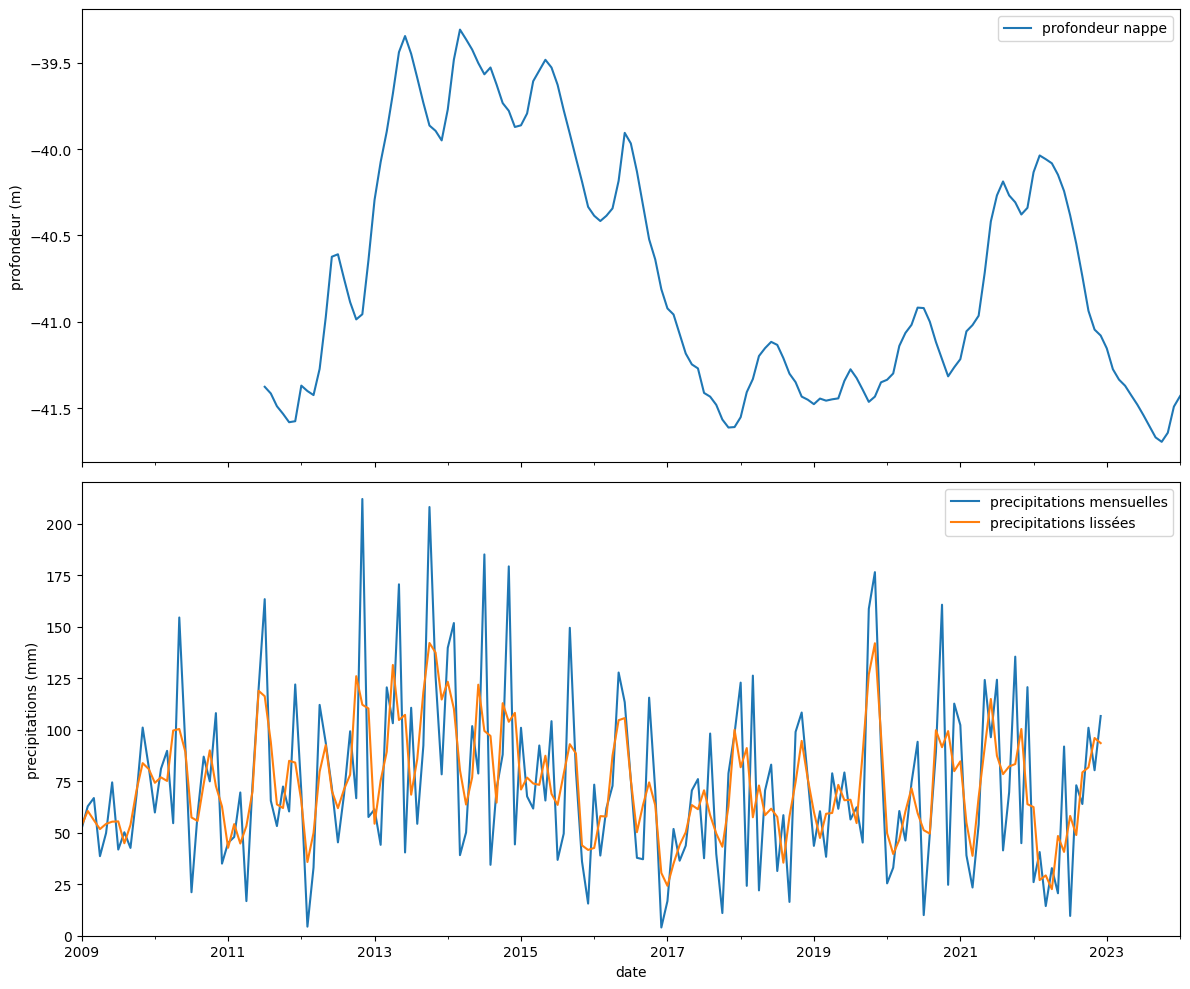

In [391]:
fig, axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
vatm.plot(ax=axes[0],label='profondeur nappe')
axes[0].set_ylabel('profondeur (m)')
stgeoirs.RR.plot(ax=axes[1],label='precipitations mensuelles')
stgeoirs.RR.rolling('90d',center=True).mean().plot(ax=axes[1],label='precipitations lissées')

axes[1].set_ylabel('precipitations (mm)')
axes[0].set_xlim(['2009','2024'])
axes[1].set_ylim([0,220])
plt.tight_layout()
axes[0].legend()
axes[1].legend()

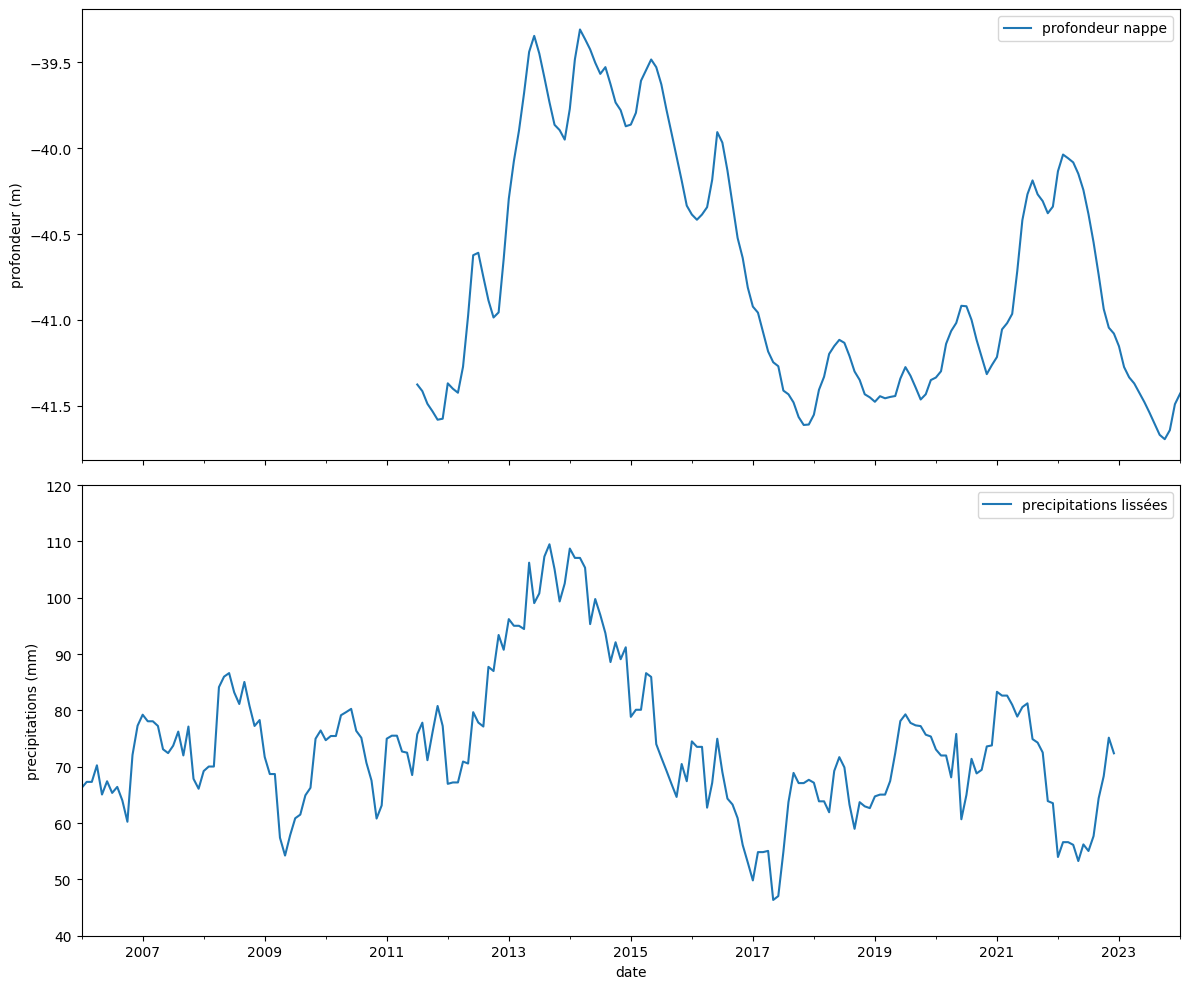

In [397]:
fig, axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
vatm.plot(ax=axes[0],label='profondeur nappe')
axes[0].set_ylabel('profondeur (m)')
stgeoirs.RR.rolling('365d',center=True).mean().plot(ax=axes[1],label='precipitations lissées')

axes[1].set_ylabel('precipitations (mm)')
axes[0].set_xlim(['2006','2024'])
axes[1].set_ylim([40,120])
plt.tight_layout()
axes[0].legend()
axes[1].legend()

/tmp/ipykernel_59774/1770090778.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)
/tmp/ipykernel_59774/1770090778.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(),c='b',fontsize=14)


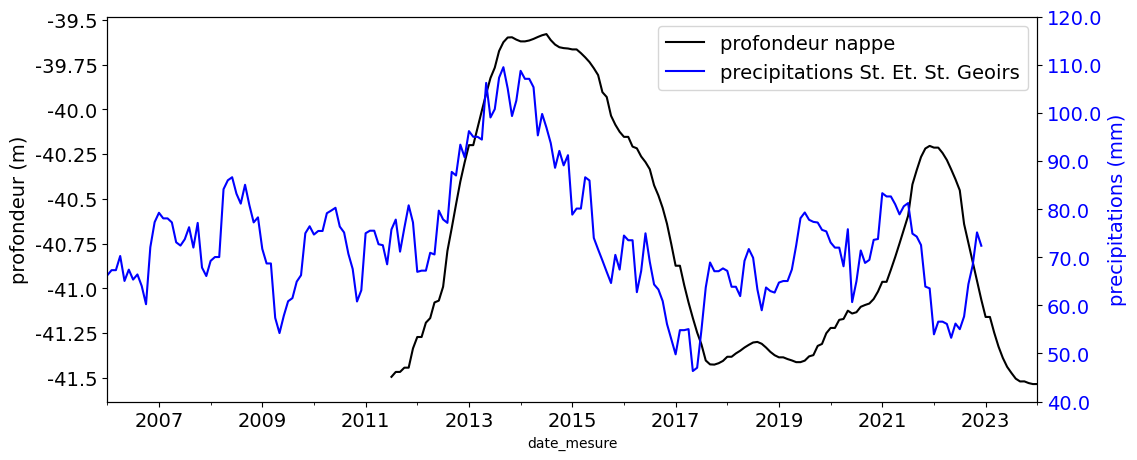

In [450]:
fig, axes = plt.subplots(1,1,figsize=(12,5),sharex=True)
lab1= vatm.rolling('365d',center=True).mean().plot(c='k',ax=axes,label='profondeur nappe',fontsize=14)
axes.set_ylabel('profondeur (m)',fontsize=14)
axes.set_yticklabels(axes.get_yticks(),c='k',fontsize=14)

ax2 = axes.twinx()

lab2 = stgeoirs.RR.rolling('365d',center=True).mean().plot(c='b',ax=ax2,label='precipitations St. Et. St. Geoirs')

ax2.set_ylabel('precipitations (mm)',c='b',fontsize=14)
ax2.set_yticklabels(ax2.get_yticks(),c='b',fontsize=14)

axes.set_xlim(['2006','2024'])
ax2.set_ylim([40,120])


lines, labels = axes.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,fontsize=14)


plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/vatilieu/vatilieu_mensuel_precip_stgeoirs_mov_avg_365d.png')

In [429]:
lab1

<AxesSubplot:xlabel='date_mesure', ylabel='profondeur (m)'>

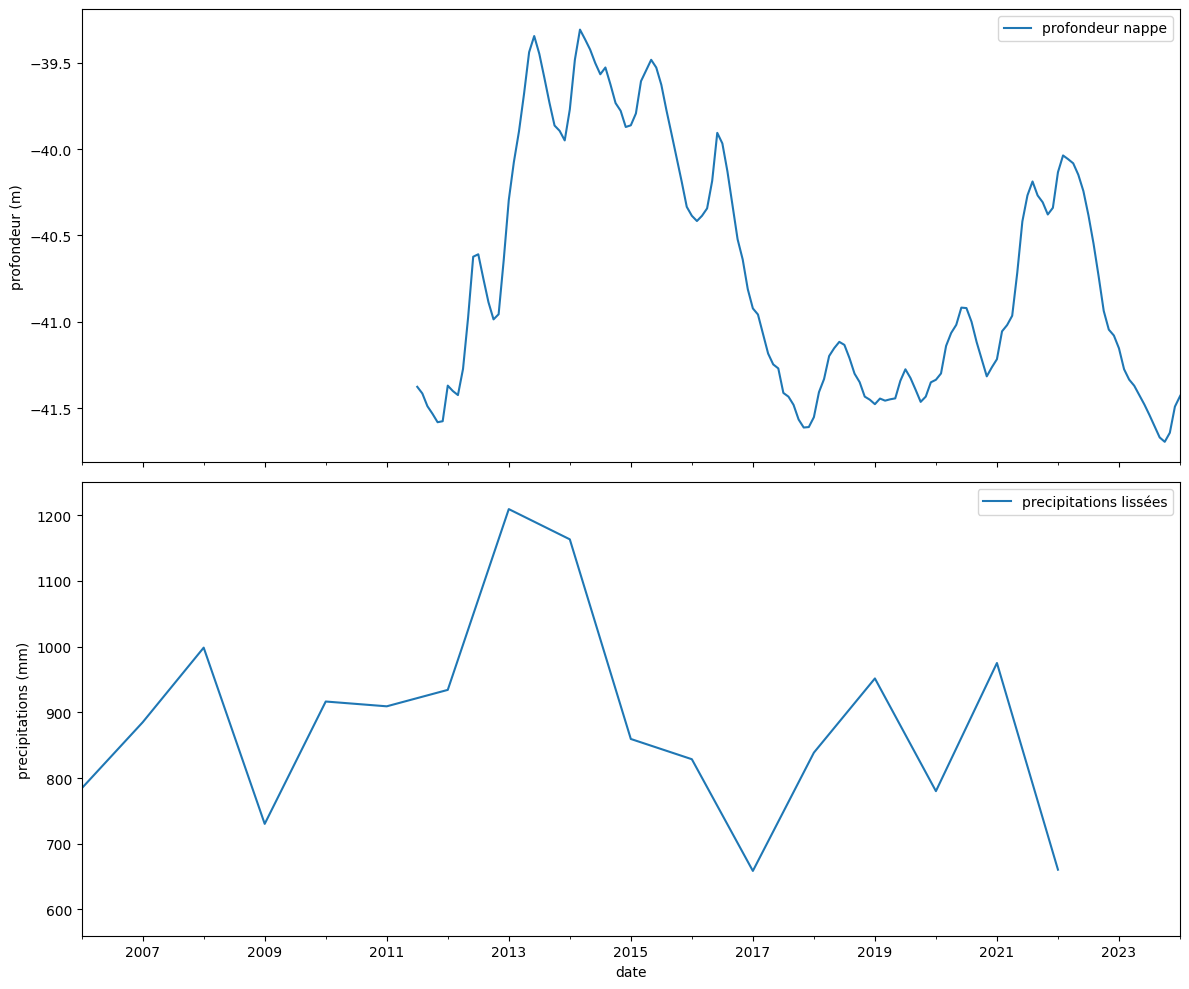

In [400]:
fig, axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
vatm.plot(ax=axes[0],label='profondeur nappe')
axes[0].set_ylabel('profondeur (m)')
stgeoirs.RR.resample('Y').sum().plot(ax=axes[1],label='precipitations lissées')

axes[1].set_ylabel('precipitations (mm)')
axes[0].set_xlim(['2006','2024'])
axes[1].set_ylim([560,1250])
plt.tight_layout()
axes[0].legend()
axes[1].legend()

In [118]:
dpths = pd.read_csv('/home/hectorb/DATA/WT/France/isere_drome/depth.csv')
dpths.set_index('date_mesure',inplace=True)
dpths.index = pd.to_datetime(dpths.index)

In [119]:
for dic in data: 
    if dic['nom_commune']=='Saint-Joseph-de-Rivière':
        code_bss_stjo = dic['code_bss']
    if dic['nom_commune']=='Saint-Étienne-de-Saint-Geoirs':
        code_bss_stet = dic['code_bss']        

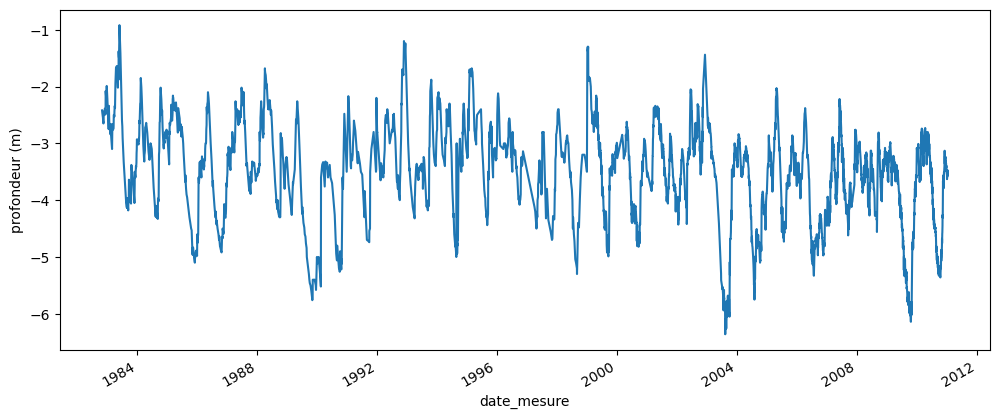

In [120]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-dpths.loc[:,code_bss_stjo]).dropna().plot(ax=axes)
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_joseph_de_riviere/saint_joseph_de_riviere.png')

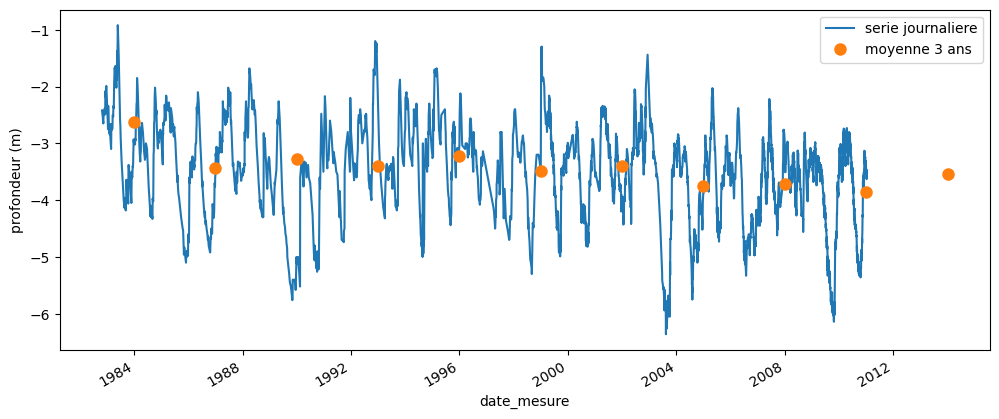

In [168]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-dpths.loc[:,code_bss_stjo]).dropna().plot(ax=axes,label='serie journaliere')

(-dpths.loc[:,code_bss_stjo]).resample('3Y',closed='right').mean().dropna().plot(style ='o',markersize=8,ax=axes,label='moyenne 3 ans')
plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_joseph_de_riviere/saint_joseph_de_riviere_et_moyenne_interannuelle.png')

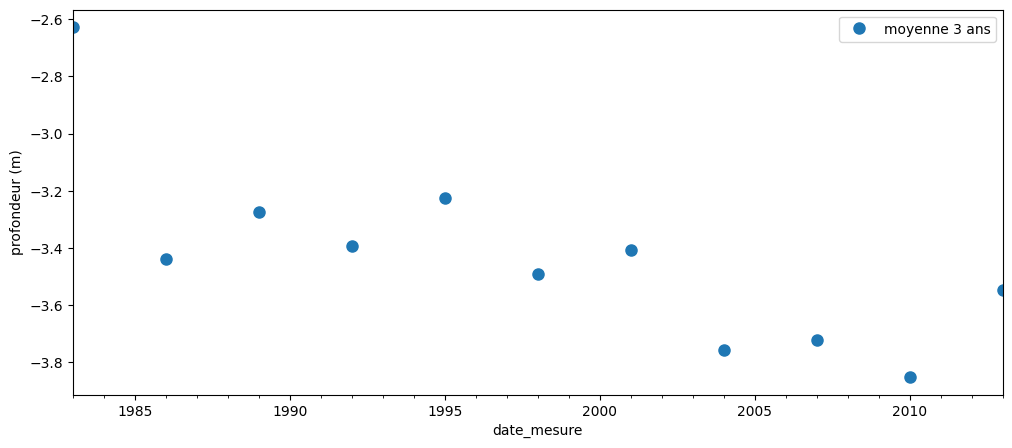

In [160]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))


(-dpths.loc[:,code_bss_stjo]).resample('3Y',closed='right').mean().dropna().plot(style ='o',markersize=8,ax=axes,label='moyenne 3 ans')
plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_joseph_de_riviere/saint_joseph_de_riviere_moyenne_interannuelle.png')

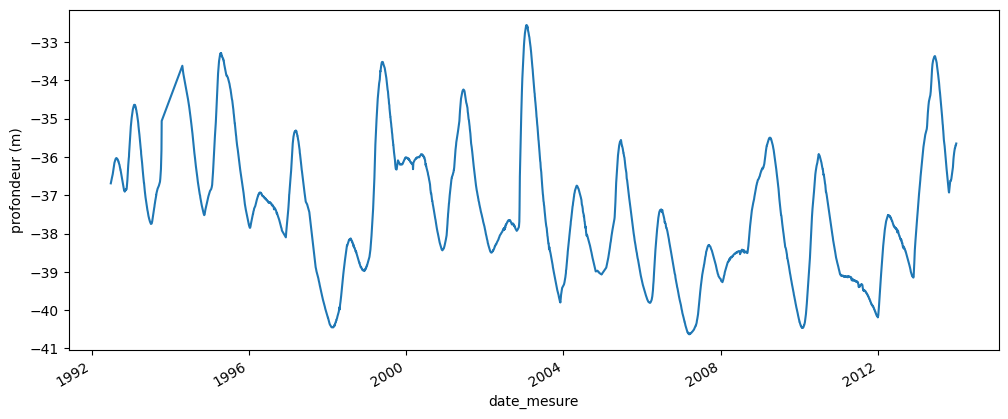

In [161]:
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-dpths.loc[:,code_bss_stet]).dropna().plot(ax=axes)
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_etienne_de_saint_geoirs/Saint-Étienne-de-Saint-Geoirs.png')

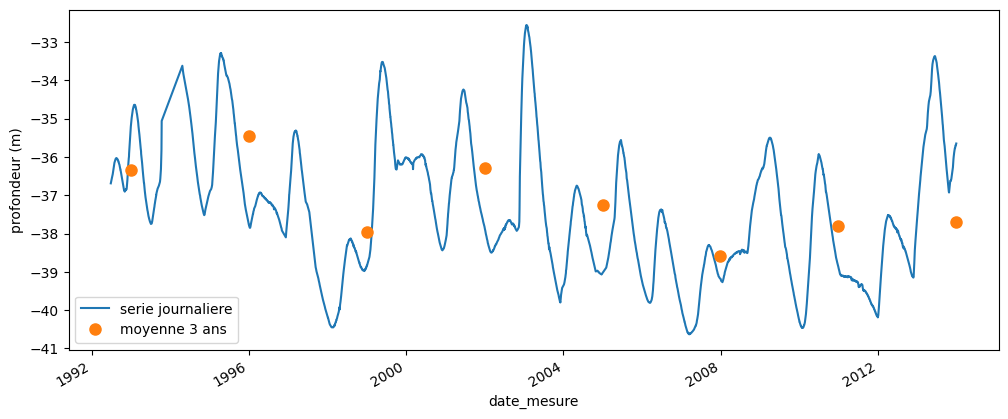

In [162]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))

(-dpths.loc[:,code_bss_stet]).dropna().plot(ax=axes,label='serie journaliere')

(-dpths.loc[:,code_bss_stet]).resample('3Y',closed='right').mean().dropna().plot(style ='o',markersize=8,ax=axes,label='moyenne 3 ans')
plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_etienne_de_saint_geoirs/saint_etienne_de_saint_geoirs_et_moyenne_interannuelle.png')

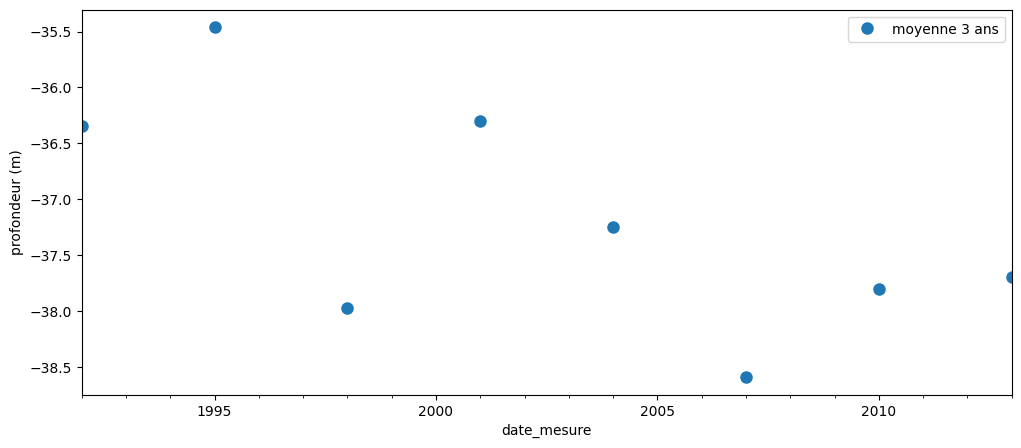

In [164]:
dpths.loc[:,code_bss_stjo].dropna()
fig, axes = plt.subplots(1,1,figsize=(12,5))


(-dpths.loc[:,code_bss_stet]).resample('3Y',closed='right').mean().dropna().plot(style ='o',markersize=8,ax=axes,label='moyenne 3 ans')
plt.legend()
axes.set_ylabel('profondeur (m)')
plt.savefig('/home/hectorb/DATA/WT/France/isere_drome/saint_etienne_de_saint_geoirs/saint_etienne_de_saint_geoirs_moyenne_interannuelle.png')

In [94]:
lev=pd.DataFrame()
dep = pd.DataFrame()
for sta in stations.loc[:,'code_bss']:
    print(sta)
    parameters[0]['value']=sta
    parameters_str = "&".join([f"{param['parameter']}={param['value']}" for param in parameters])
    hubeau_url = f"{base}/{endpoint}/{operation}?{parameters_str}"
    # Récupération de la 1ère page de résultats
    response = requests.get(hubeau_url)
    # Conversion de la chaîne de texte au format json dans un dictionnaire python
    response = response.json()
    if response['data']:
        tmp_lev = pd.DataFrame(response['data']).loc[:,['date_mesure','niveau_nappe_eau']].set_index('date_mesure').rename(columns={"niveau_nappe_eau":sta})
        tmp_dep = pd.DataFrame(response['data']).loc[:,['date_mesure','profondeur_nappe']].set_index('date_mesure').rename(columns={"profondeur_nappe":sta})
        lev = pd.concat([lev,tmp_lev],axis=1)
        dep = pd.concat([dep,tmp_dep],axis=1)

07968X0186/RE11
08915X0028/PMA-B1
08422X0190/F1
07948X0047/F1
07497X0097/F1
07477X0048/F1
08664X0069/F1
07703X0064/P1
08187X0238/P1
07955X0099/P1
08184X0084/PZ1
07733X0070/F2
08422X0191/F2
08907X1014/F2
08424X0006/F2
08426X0133/P2
07955X0101/PZ2
07703X0069/F83
07725X0071/F3
07475X0008/F3
07464X0005/SM3
07733X0063/PZ3
07497X0043/P4
08905X1093/PZ5
08211X0072/PZ7
08188X0085/F268
08435X0010/NO8
07496X0007/38446A
07975X0081/PGB
07732X0051/38214C
07497X0071/38314C
07472X0012/399C
07703X0043/SDC
07732X0087/PZD
08668X0029/SCE
09165X0008/HANE
08905X1084/LATTE
07238X0110/F
07235X0011/F
07488X0011/F
08907X1012/F
07965X0092/F
07237X0113/F
08904X0033/F
07472X0024/F
07707X0144/F
07714X0054/F
07466X0054/F
08188X0054/F
07497X0205/F
07704X0007/F
08915X1007/F
07952X0027/F
08662X0408/F
07951X0028/F
07944X0409/F
07482X0049/F
07733X0049/F
07948X0049/F
07733X0059/F
07228X0017/PZF
08184X0066/DRAIN
07707X0039/ALBON
08188X0045/BERN
08904X1010/P
09163X0020/P
07955X0111/P
08663X0091/P
09152X0012/P
08191X0022/P
0

In [113]:
dep.sort_index(inplace=True)
lev.sort_index(inplace=True)
dep.index = pd.to_datetime(dep.index)
lev.index = pd.to_datetime(lev.index)


In [114]:
dep.to_csv('/home/hectorb/DATA/WT/France/isere_drome/depth.csv')
lev.to_csv('/home/hectorb/DATA/WT/France/isere_drome/levels.csv')

<AxesSubplot:xlabel='date_mesure'>

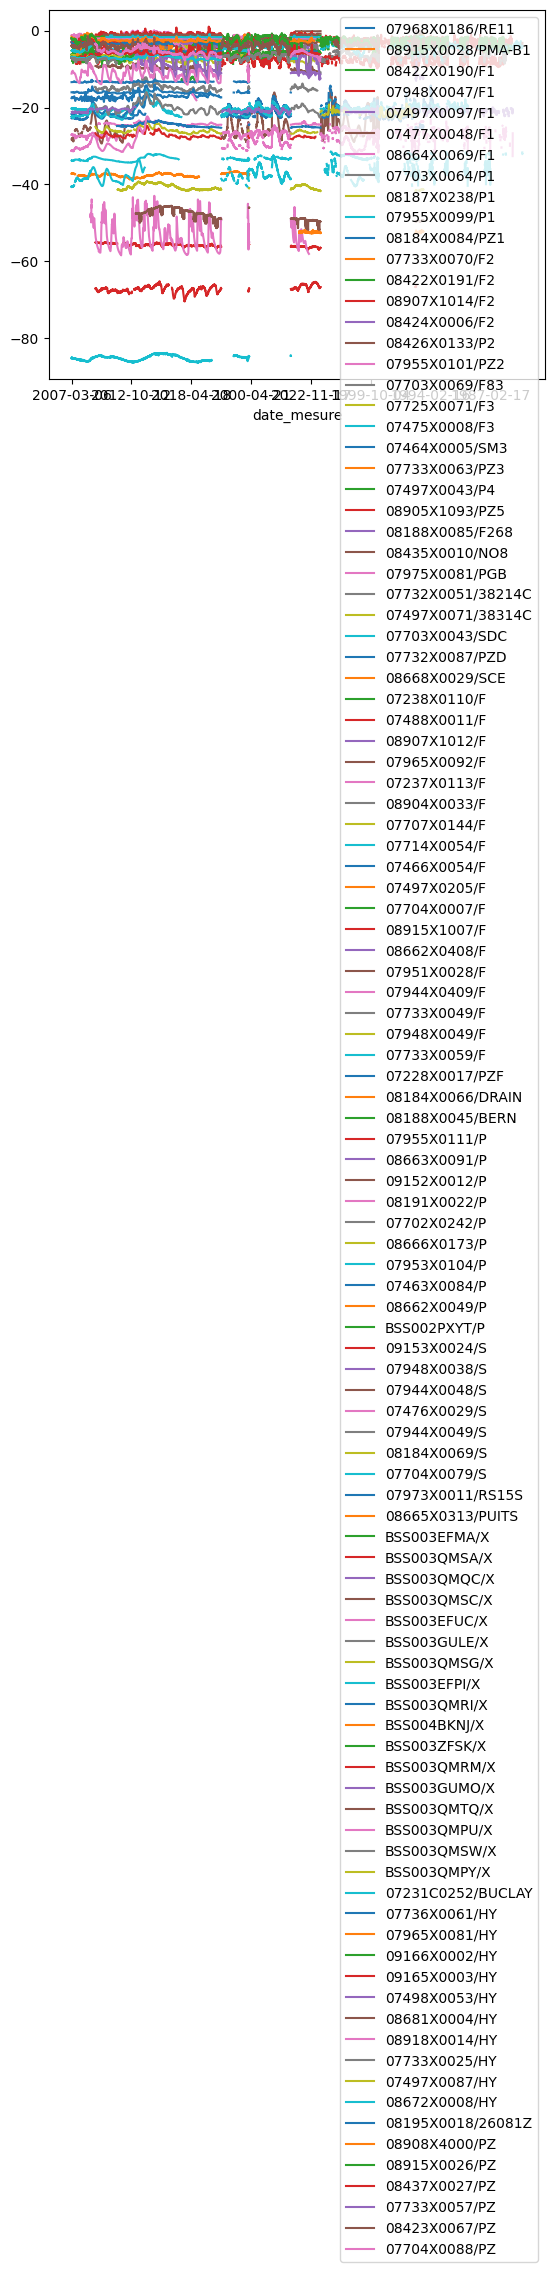

In [59]:
(-dep).plot()